In [83]:
# Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime

from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
# import re

from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb

In [31]:
# Load the required data files as pandas dataframe
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
print(test.shape)

(74111, 29)
(25458, 28)


In [32]:
# Do a subset for learning purposes
train = train[:5000]
test = test[:500]
print(train.shape)
print(test.shape)

(5000, 29)
(500, 28)


In [33]:
# Have a quick look at the dataset
train.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


## Target Variable

In [34]:
# from scipy.stats import skew
# print(skew(train['log_price']))

# from scipy.stats import boxcox
# transformed_log_price = boxcox(train[train['log_price']!=0]['log_price'])
# # transformed_log_price[0]
# print(skew(transformed_log_price[0]))
# print(len(transformed_log_price[0]))


 mu = 4.79 and sigma = 0.71



C:\Users\ankuarora\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


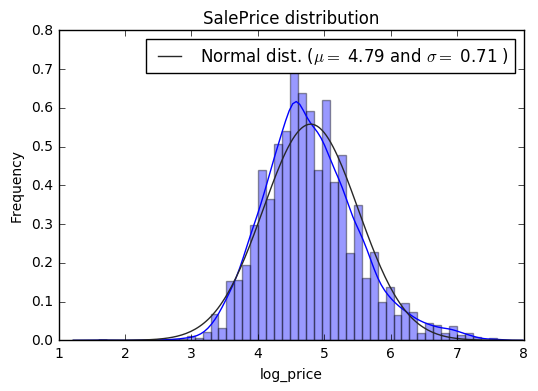

In [35]:
# Check the distribution
sns.distplot(train['log_price'] , fit=norm)

(mu, sigma) = norm.fit(train['log_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

## Missing Values

In [36]:
# combine train and test data
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.log_price.values

data = pd.concat([train,test], axis = 0).reset_index(drop=True).drop('log_price', axis=1)
data.shape

(5500, 28)

In [37]:
data.head()

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,...,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
0,3,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,1.0,1.0,strict,NYC,True,"Beautiful, sunlit brownstone 1-bedroom in the ...",...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201
1,7,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,3.0,3.0,strict,NYC,True,Enjoy travelling during your stay in Manhattan...,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,Apartment,93.0,Entire home/apt,https://a0.muscache.com/im/pictures/348a55fe-4...,10019
2,5,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1.0,Real Bed,1.0,3.0,moderate,NYC,True,The Oasis comes complete with a full backyard ...,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,Apartment,92.0,Entire home/apt,https://a0.muscache.com/im/pictures/6fae5362-9...,10027
3,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1.0,Real Bed,2.0,2.0,flexible,SF,True,This light-filled home-away-from-home is super...,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,House,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,0.0,1.0,moderate,DC,True,"Cool, cozy, and comfortable studio located in ...",...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,Apartment,40.0,Entire home/apt,NaN,20009


In [38]:
# Propotion of missing values
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
data_na

host_response_rate        25.254545
review_scores_rating      23.436364
first_review              22.290909
last_review               22.218182
thumbnail_url             10.963636
neighbourhood              9.072727
zipcode                    1.363636
host_since                 0.381818
host_identity_verified     0.381818
host_has_profile_pic       0.381818
bathrooms                  0.254545
beds                       0.200000
bedrooms                   0.090909
dtype: float64

## Data Correlation

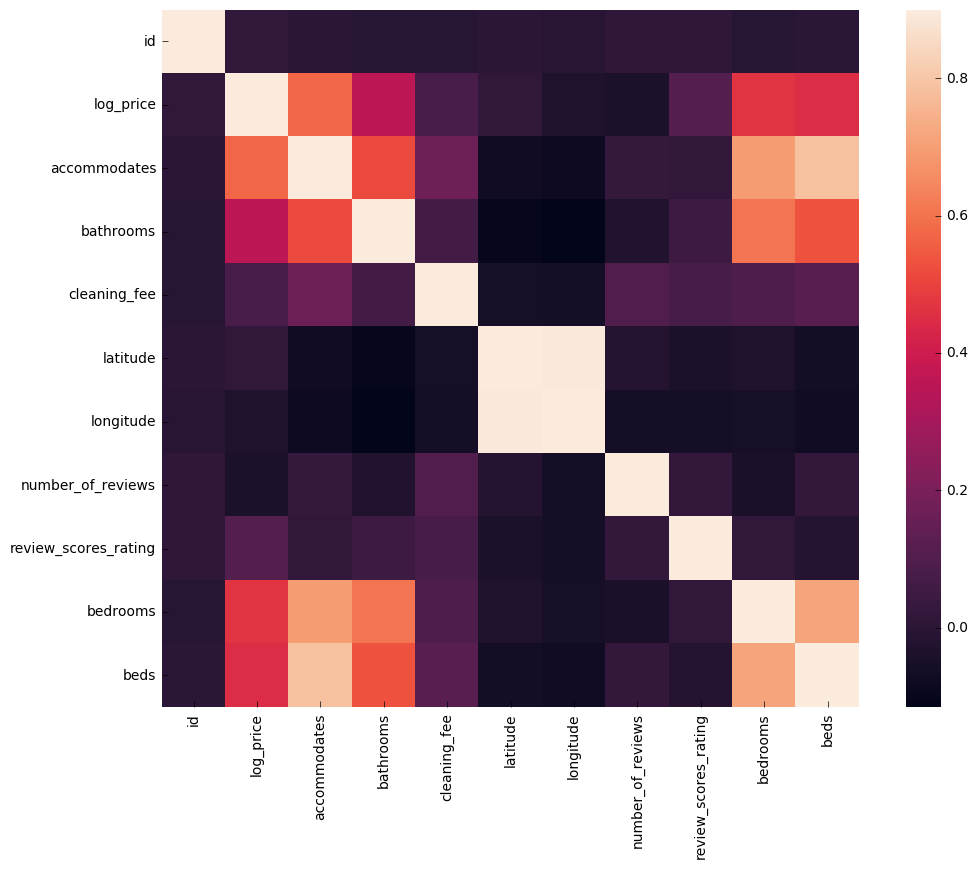

In [39]:
# Correlation map to see how features are correlated
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

## Imputing missing values & some feature engineering

In [40]:
# host_response_rate
data['host_response_rate'] = data['host_response_rate'].fillna(value='100%').apply(lambda x: float(x[:-1]))
# median

In [41]:
# review_scores_rating
data['review_scores_rating'] = data['review_scores_rating'].fillna(value = data['review_scores_rating'].median())

In [42]:
# first_review - To be converted to first_review_since
cutoff = '2017-12-31'
data['first_review_since'] = datetime.strptime(cutoff, '%Y-%m-%d') - data['first_review'].fillna(value=cutoff). \
                                                                    apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['first_review_since'] = data['first_review_since'].apply(lambda x: x.days)
data.drop('first_review', axis=1, inplace=True)

In [43]:
# last_review - To be converted to last_review_since
data['last_review_since'] = datetime.strptime(cutoff, '%Y-%m-%d') - data['last_review'].fillna(value=cutoff). \
                                                                    apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['last_review_since'] = data['last_review_since'].apply(lambda x: x.days)
data.drop('last_review', axis=1, inplace=True)

In [44]:
# thumbnail_url - To be converted to binary yes/no (0/1)
data['thumbnail_url'] = data['thumbnail_url'].fillna(value='').apply(lambda x: 0 if x=='' else 1)
# NA imputataion

In [45]:
# neighbourhood & zipcode
data['neighbourhood'] = data['zipcode'].fillna(value='00000').apply(lambda x: x.replace('.0','')[:5]) + '_' + \
                            data['neighbourhood'].fillna(value='')
data.drop('zipcode', axis=1, inplace=True)

In [46]:
# bathrooms
data['bathrooms'] = data.groupby('bedrooms')['bathrooms'].transform(lambda x: x.fillna(x.median()))

In [47]:
# host_since
data['host_since'] = datetime.strptime(cutoff, '%Y-%m-%d') - data['host_since'].fillna(value=cutoff). \
                                                                    apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['host_since'] = data['host_since'].apply(lambda x: x.days)

In [48]:
# host_has_profile_pic, host_identity_verified
for col in ('host_has_profile_pic', 'host_identity_verified'):
    data[col] = data[col].fillna(data[col].mode()[0])

In [49]:
# beds, bedrooms, bathrooms (very low % missing)
for col in ('beds', 'bedrooms', 'bathrooms'):
    data[col] = data[col].fillna(value=0)

In [50]:
# name, description (very low % missing)
for col in ('name', 'description'):
    data[col] = data[col].fillna(value='NA')

In [51]:
# Recheck propotion of missing values - must be blank now!
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
data_na

Series([], dtype: float64)

In [52]:
# Transforming numerical variables that are really categorical
data['thumbnail_url'] = data['thumbnail_url'].apply(str)
# data['cancellation_policy'] = data['cancellation_policy'].apply(str)

In [53]:
data.head()

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,first_review_since,last_review_since
0,3,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,1.0,1.0,strict,NYC,True,"Beautiful, sunlit brownstone 1-bedroom in the ...",...,-73.991617,Beautiful brownstone 1-bedroom,11201_Brooklyn Heights,2,Apartment,100.0,Entire home/apt,1,561,531
1,7,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,3.0,3.0,strict,NYC,True,Enjoy travelling during your stay in Manhattan...,...,-73.989040,Superb 3BR Apt Located Near Times Square,10019_Hell's Kitchen,6,Apartment,93.0,Entire home/apt,1,148,99
2,5,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1.0,Real Bed,1.0,3.0,moderate,NYC,True,The Oasis comes complete with a full backyard ...,...,-73.943756,The Garden Oasis,10027_Harlem,10,Apartment,92.0,Entire home/apt,1,245,108
3,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1.0,Real Bed,2.0,2.0,flexible,SF,True,This light-filled home-away-from-home is super...,...,-122.431619,Beautiful Flat in the Heart of SF!,94117_Lower Haight,0,House,96.0,Entire home/apt,1,0,0
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,0.0,1.0,moderate,DC,True,"Cool, cozy, and comfortable studio located in ...",...,-77.034596,Great studio in midtown DC,20009_Columbia Heights,4,Apartment,40.0,Entire home/apt,0,964,343


In [54]:
# Defining features
categorical = ['bed_type', 'cancellation_policy', 'city', 'host_has_profile_pic', 'cleaning_fee', \
               'host_identity_verified', 'instant_bookable', 'neighbourhood', 'property_type', 'room_type', \
               'thumbnail_url']
numerical = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'host_response_rate', 'host_since', 'number_of_reviews', \
            'review_scores_rating', 'first_review_since', 'last_review_since']
text = ['amenities']
ignored = ['id', 'latitude', 'longitude', 'description', 'name']

data_id = data['id'].values
data = data[categorical + numerical + text]

## Skewed features

In [55]:
# Check the skew of all numerical features
skewed_feats = data[numerical].apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'skew' :skewed_feats})
skewness


Skew in numerical features: 



,skew
number_of_reviews,3.666357
bathrooms,3.339403
beds,3.310977
accommodates,2.295811
bedrooms,1.962026
last_review_since,1.818452
first_review_since,1.297194
host_since,0.443674
review_scores_rating,-4.396566
host_response_rate,-4.669533


In [56]:
# Box Cox Transformation of (highly) skewed features
skewness = skewness[skewness['skew'] > 0.75]
# skewness = skewness[abs(skewness) > 0.75] -ve skewness increased with boxcox, hence only performed for +ve ones

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)

In [57]:
# Re check the skew of all numerical features
skewed_feats = data[numerical].apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features after transformation: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features after transformation: 



,Skew
bathrooms,2.100553
beds,1.597661
accommodates,0.879928
number_of_reviews,0.644740
host_since,0.443674
bedrooms,0.314676
last_review_since,-0.855782
first_review_since,-0.921363
review_scores_rating,-4.396566
host_response_rate,-4.669533


## Getting dummy categorical features

In [58]:
data = pd.get_dummies(data, columns=categorical)
data.head()

,accommodates,bathrooms,bedrooms,beds,host_response_rate,host_since,number_of_reviews,review_scores_rating,first_review_since,last_review_since,...,property_type_Serviced apartment,property_type_Timeshare,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,thumbnail_url_0,thumbnail_url_1
0,1.540963,0.730463,0.730463,0.730463,100.0,2106,1.194318,100.0,10.566663,10.425436,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2.440268,0.730463,1.540963,1.540963,100.0,195,2.259674,93.0,7.455024,6.635082,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2.055642,0.730463,0.730463,1.540963,100.0,432,2.885846,92.0,8.558043,6.808145,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.820334,0.730463,1.194318,1.194318,100.0,987,0.000000,96.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.194318,0.730463,0.000000,0.730463,100.0,1036,1.820334,40.0,12.022410,9.343377,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Handling text features

In [59]:
# amenities
amenities = data['amenities'].apply(lambda x: x.replace(' ',''))
vec = CountVectorizer()
amenities = pd.DataFrame(vec.fit_transform(amenities).toarray(), columns = vec.get_feature_names())
data = data.drop('amenities', axis=1).join(amenities)
data.shape

(5500, 1262)

In [66]:
# # name
# stop = set(nltk.corpus.stopwords.words('english'))
# name = data['name']
# vec = CountVectorizer(stop_words=stop)
# name = pd.DataFrame(vec.fit_transform(name).toarray(), columns = vec.get_feature_names())
# # data = data.drop('name', axis=1).join(name, rsuffix='_name')
# # data.shape

In [68]:
# name_words = []
# for idx, val in name.sum().items():
#     if ((len(idx) > 2) & (val > 2)):
#         name_words.append(idx)
# print(name_words)

In [33]:
# description
# description = data['description']
# vec = TfidfVectorizer(stop_words=stop)
# description = pd.DataFrame(vec.fit_transform(description).toarray(), columns = vec.get_feature_names())
# data = data.drop('description', axis=1)
# # .join(description)
# data.shape

## Modelling

In [61]:
# Define a cross validation strategy
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(train_red)
    rmse= np.sqrt(-cross_val_score(model, train_red, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### Feature Reduction

In [62]:
print('No of original features: {}'.format(data.shape[1])) 

No of original features: 1262


In [67]:
# Split train and test feature space
train = data[:ntrain]
test = data[ntrain:]
# experiment only
# train = data[:2000]
# test = data[-500:]

In [68]:
# Perform dimension reduction
pca = PCA(n_components = train.shape[1]).fit(train)
print(list(pca.explained_variance_ratio_.cumsum())[:100])

[0.99925026526639604, 0.99974337068967145, 0.99987494672982447, 0.99995362013891431, 0.99996240762410449, 0.99996747912425399, 0.99997054247490647, 0.99997237217011881, 0.9999738214230125, 0.99997517161357241, 0.99997635611095015, 0.9999774237755561, 0.99997844289319038, 0.99997937694608174, 0.99998022787586383, 0.99998102716572101, 0.99998181627675942, 0.99998253223751921, 0.99998323111028431, 0.99998388591471832, 0.99998452753991318, 0.9999850798468396, 0.99998559866721215, 0.99998608168681946, 0.99998653580053831, 0.99998697421117533, 0.9999873922670679, 0.99998779640047608, 0.99998818746621354, 0.99998856691659688, 0.9999889395946675, 0.99998930768968708, 0.99998965610189106, 0.99998999008275602, 0.9999903149665742, 0.99999061900446251, 0.99999091199013723, 0.99999119611561493, 0.99999146053308841, 0.99999171605409032, 0.99999196115493438, 0.99999219450028531, 0.99999241912082171, 0.99999263802816252, 0.99999285375251201, 0.99999306625916695, 0.99999327304821373, 0.9999934668053240

In [69]:
ncomp = 100
pca = PCA(n_components = ncomp).fit(train)
train_red = pca.transform(train)
print('No of reduced features: {}'.format(ncomp))

No of reduced features: 100


In [70]:
#### NOT USING PCA FOR NOW ####
train_red = train

#### Base models

In [71]:
# LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

In [78]:
score = rmse_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4430 (0.0147)



In [109]:
# Parameter Tuning - Lasso
parameters = {
    'alpha': [0.0001, 0.0002, 0.0003, 0.0004],
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
score = 'rmse'
clf = GridSearchCV(Lasso(), parameters, cv = 5, scoring = 'neg_mean_squared_error')
clf.fit(train_red, y_train)
params_lasso = clf.best_estimator_

C:\Users\ankuarora\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ankuarora\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ankuarora\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ankuarora\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\

In [110]:
params_lasso

Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [111]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0003, random_state=1))

In [112]:
score = rmse_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4402 (0.0146)



In [72]:
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [73]:
# Support Vector Regression
svr = make_pipeline(RobustScaler(), SVR(kernel='poly', degree=2, coef0=2.5)) 

In [41]:
# Kernel Ridge Regression
# KRR = KernelRidge(alpha=0.6, kernel='poly', degree=2, coef0=2.5)

In [74]:
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [113]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [115]:
score = rmse_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.4304 (0.0096)



In [76]:
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#### Base models scores

In [46]:
score = rmse_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.4355 (0.0028)



In [47]:
score = rmse_cv(svr)
print("Support Vector score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Support Vector score: 0.4336 (0.0034)



In [48]:
# score = rmse_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [49]:
score = rmse_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.3962 (0.0037)



Xgboost score: 0.3922 (0.0039)



In [51]:
score = rmse_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.4147 (0.0037)



#### Stacking Base Models

In [45]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=999)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [57]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, svr),
                                                 meta_model = lasso)

# score = rmse_cv(stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

#### Ensembling StackedRegressor, XGBoost and LightGBM

In [48]:
# Transform test datax
print(test.shape)
test_red = pca.transform(test)
print(test_red.shape)

(25458, 2624)
(25458, 100)


In [49]:
#### NOT USING PCA FOR NOW ####
test_red = test

In [ ]:
# Stacked Average Model
stacked_averaged_models.fit(train, y_train)

In [51]:
stacked_pred = stacked_averaged_models.predict(test.values)

In [52]:
# XGBoost
model_xgb.fit(train, y_train)
xgb_pred = model_xgb.predict(test)

In [53]:
# LightGBM
model_lgb.fit(train, y_train)
lgb_pred = model_lgb.predict(test)

In [54]:
# Ensemble prediction
ensemble = stacked_pred * 0.50 + xgb_pred * 0.25 + lgb_pred * 0.25

## Submission

In [56]:
# Make predictions
sub = pd.DataFrame()
sub['id'] = data_id[ntrain:]
sub['log_price'] = ensemble
sub.to_csv('submission_v2.csv',index=False)